# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

**Business Problem Statement:
Objective here is to provide a used car dealership, the client, recommendations on what the customer values in a used car.  In order to achieve this, we need to understand the factors that make a car more expensive, since the car dealers will need to communicate to the end clients what features would be missing if the client is looking for cheaper cars, and also what features need to be present if they want to sell expensive cars to more clients.  Data analysis will need to be done to understand which factors correlate well to used car prices and which don't.**

In [2]:
# importing the Python libraries, classes, etc, here
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans, DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

*First step would be to load the data into pandas.*

In [4]:
used_cars = pd.read_csv('data/vehicles.csv')

_Next step would be to check for these within the dataset:
Which columns/features are categorical and which are numeric
Presence of any missing data
Whether or not scaling would be required_

In [5]:
used_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [6]:
used_cars.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [7]:
# get rid of missing data for numeric columns
# year column has 1205 NaNs while odometer column has 4400 NaNs
# These are 426880 total entries/samples, so above NaNs are either approx. 1% or less
cars2 = used_cars.copy()
cars2.dropna(subset = ['year', 'odometer'], inplace=True)


# fill in missing data for object columns, and delete them later after converting to numeric
objects_df = cars2.select_dtypes(include='object')
objects_cols = list(objects_df.columns)
cars2.fillna('null', inplace=True)
cars2.isnull().sum()

id              0
region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
VIN             0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64

In [8]:
## since less than 2% of data involves price >= 100000, 
## removing these outliers to make data analyis and modeling easier
cars3 = cars2[cars2['price'] < 1e5]
cars3.shape

(420656, 18)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'clean'),
  Text(1, 0, 'rebuilt'),
  Text(2, 0, 'lien'),
  Text(3, 0, 'null'),
  Text(4, 0, 'salvage'),
  Text(5, 0, 'missing'),
  Text(6, 0, 'parts only')])

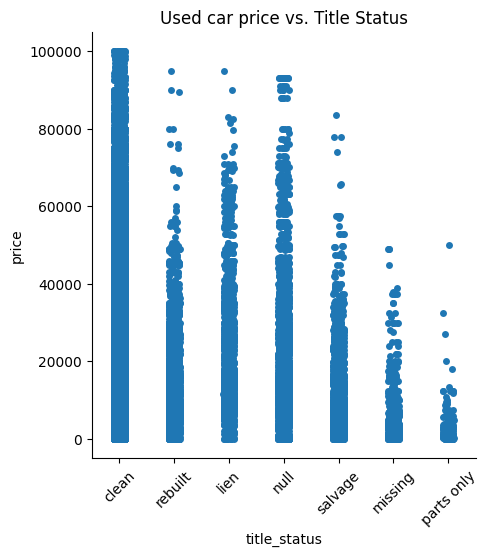

In [11]:
## I started looking at catplots to see any trends within categorical data that affect car prices
sns.catplot(x='title_status', y='price', data=cars3)
plt.title('Used car price vs. Title Status')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'clean'),
  Text(1, 0, 'lien'),
  Text(2, 0, 'missing'),
  Text(3, 0, 'null'),
  Text(4, 0, 'parts only'),
  Text(5, 0, 'rebuilt'),
  Text(6, 0, 'salvage')])

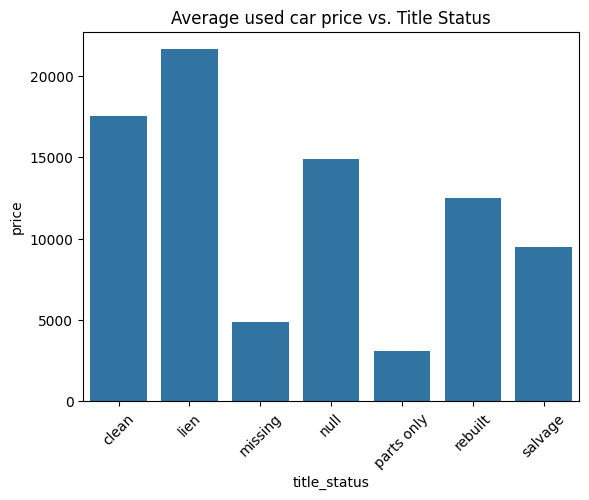

In [12]:
## Later I decided to aggregate some of the categorical data by mean, to see which of these features
## affect car prices.  I plotted these using bar plot below.
title_status = cars3.groupby('title_status')[['price']].agg('mean')

sns.barplot(x=title_status.index, y='price', data=title_status)
plt.title('Average used car price vs. Title Status')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'excellent'),
  Text(1, 0, 'fair'),
  Text(2, 0, 'good'),
  Text(3, 0, 'like new'),
  Text(4, 0, 'new'),
  Text(5, 0, 'null'),
  Text(6, 0, 'salvage')])

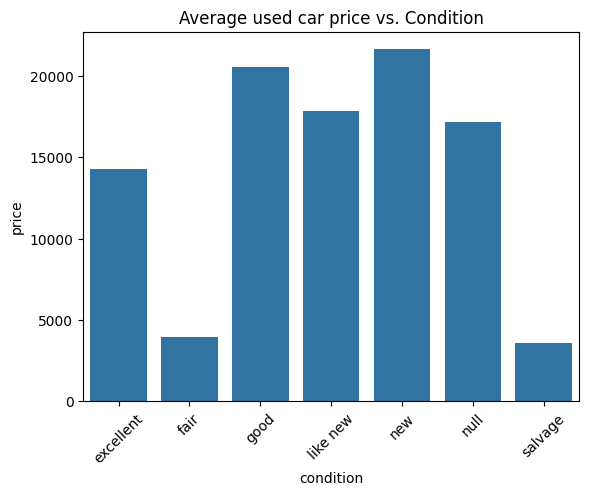

In [13]:
df_feature = cars3.groupby('condition')[['price']].agg('mean')
sns.barplot(x=df_feature.index, y='price', data=df_feature)
plt.title('Average used car price vs. Condition')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, '10 cylinders'),
  Text(1, 0, '12 cylinders'),
  Text(2, 0, '3 cylinders'),
  Text(3, 0, '4 cylinders'),
  Text(4, 0, '5 cylinders'),
  Text(5, 0, '6 cylinders'),
  Text(6, 0, '8 cylinders'),
  Text(7, 0, 'null'),
  Text(8, 0, 'other')])

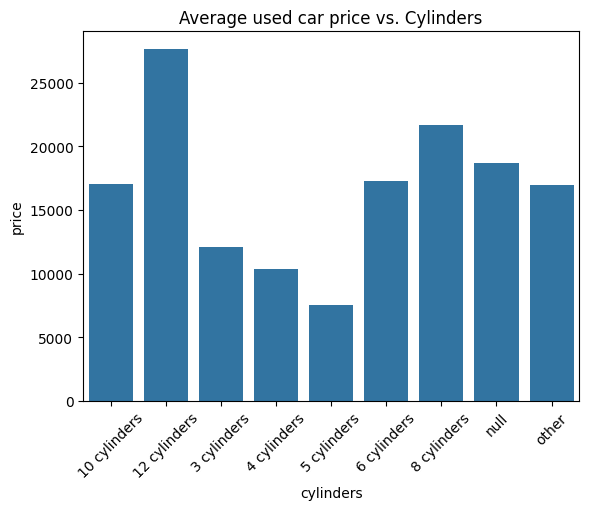

In [14]:
df_feature = cars3.groupby('cylinders')[['price']].agg('mean')
sns.barplot(x=df_feature.index, y='price', data=df_feature)
plt.title('Average used car price vs. Cylinders')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'diesel'),
  Text(1, 0, 'electric'),
  Text(2, 0, 'gas'),
  Text(3, 0, 'hybrid'),
  Text(4, 0, 'null'),
  Text(5, 0, 'other')])

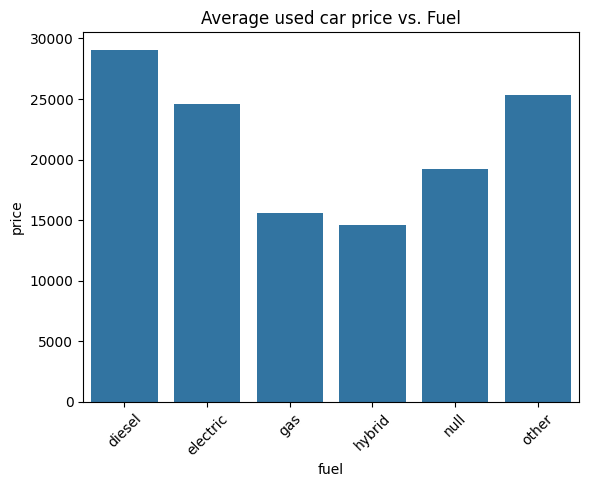

In [15]:
df_feature = cars3.groupby('fuel')[['price']].agg('mean')
sns.barplot(x=df_feature.index, y='price', data=df_feature)
plt.title('Average used car price vs. Fuel')
plt.xticks(rotation=45)

([0, 1, 2, 3],
 [Text(0, 0, 'automatic'),
  Text(1, 0, 'manual'),
  Text(2, 0, 'null'),
  Text(3, 0, 'other')])

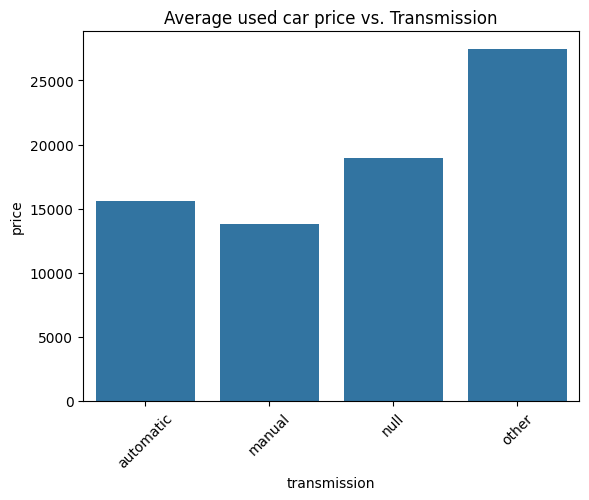

In [16]:
df_feature = cars3.groupby('transmission')[['price']].agg('mean')
sns.barplot(x=df_feature.index, y='price', data=df_feature)
plt.title('Average used car price vs. Transmission')
plt.xticks(rotation=45)

([0, 1, 2, 3],
 [Text(0, 0, '4wd'), Text(1, 0, 'fwd'), Text(2, 0, 'null'), Text(3, 0, 'rwd')])

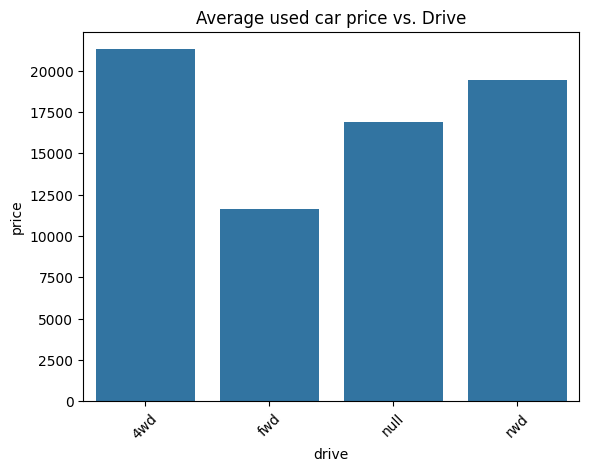

In [17]:
df_feature = cars3.groupby('drive')[['price']].agg('mean')
sns.barplot(x=df_feature.index, y='price', data=df_feature)
plt.title('Average used car price vs. Drive')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'compact'),
  Text(1, 0, 'full-size'),
  Text(2, 0, 'mid-size'),
  Text(3, 0, 'null'),
  Text(4, 0, 'sub-compact')])

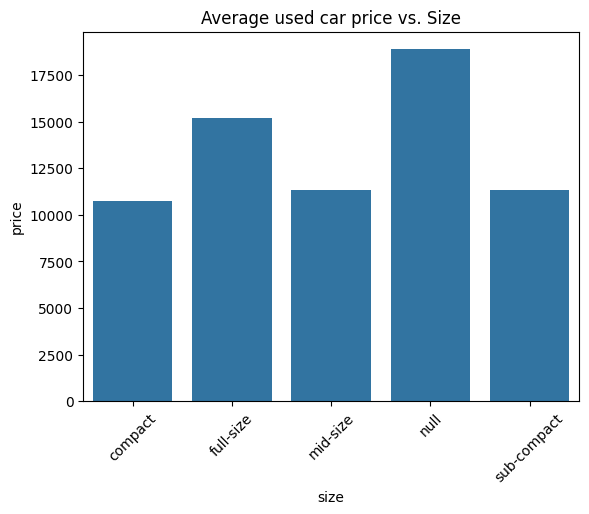

In [18]:
df_feature = cars3.groupby('size')[['price']].agg('mean')
sns.barplot(x=df_feature.index, y='price', data=df_feature)
plt.title('Average used car price vs. Size')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'SUV'),
  Text(1, 0, 'bus'),
  Text(2, 0, 'convertible'),
  Text(3, 0, 'coupe'),
  Text(4, 0, 'hatchback'),
  Text(5, 0, 'mini-van'),
  Text(6, 0, 'null'),
  Text(7, 0, 'offroad'),
  Text(8, 0, 'other'),
  Text(9, 0, 'pickup'),
  Text(10, 0, 'sedan'),
  Text(11, 0, 'truck'),
  Text(12, 0, 'van'),
  Text(13, 0, 'wagon')])

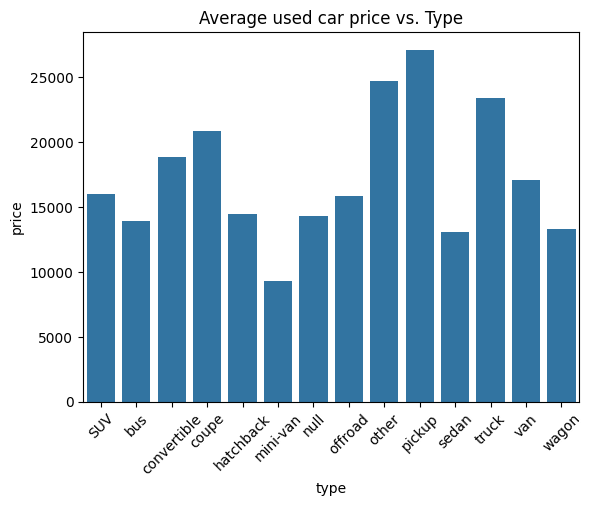

In [19]:
df_feature = cars3.groupby('type')[['price']].agg('mean')
sns.barplot(x=df_feature.index, y='price', data=df_feature)
plt.title('Average used car price vs. Type')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'black'),
  Text(1, 0, 'blue'),
  Text(2, 0, 'brown'),
  Text(3, 0, 'custom'),
  Text(4, 0, 'green'),
  Text(5, 0, 'grey'),
  Text(6, 0, 'null'),
  Text(7, 0, 'orange'),
  Text(8, 0, 'purple'),
  Text(9, 0, 'red'),
  Text(10, 0, 'silver'),
  Text(11, 0, 'white'),
  Text(12, 0, 'yellow')])

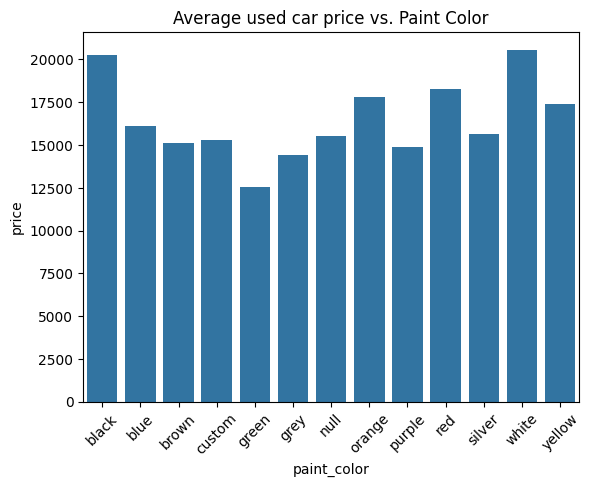

In [20]:
df_feature = cars3.groupby('paint_color')[['price']].agg('mean')
sns.barplot(x=df_feature.index, y='price', data=df_feature)
plt.title('Average used car price vs. Paint Color')
plt.xticks(rotation=45)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


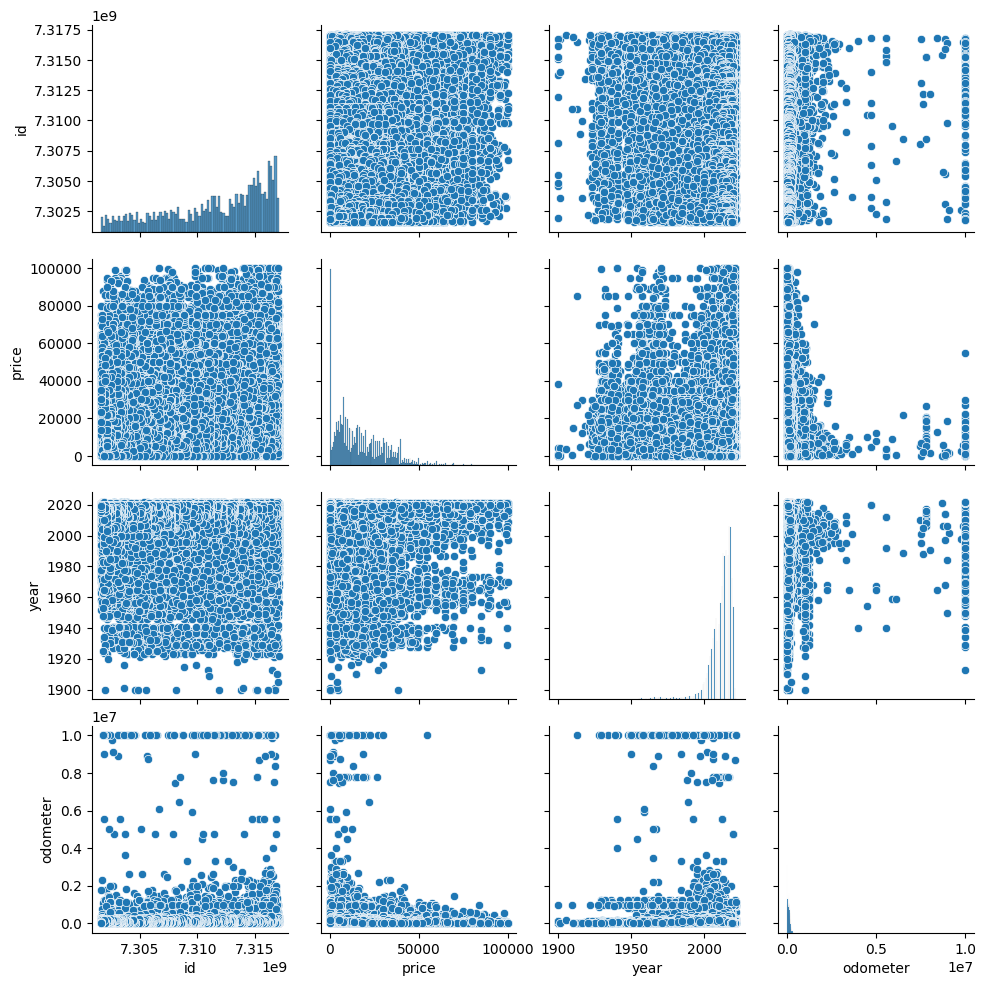

In [ ]:
sns.pairplot(cars3)

In [48]:
cars3['log_price'] = np.log10(cars3['price'])
cars3[['year','odometer','price','log_price']].corr()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log10

/var/folders/2p/wbd1ych569902w1lzzpgpgzh0000gn/T/ipykernel_948/3127210428.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,year,odometer,price,log_price
year,1.000000,-0.157011,0.292538,0.274107
odometer,-0.157011,1.000000,-0.147586,-0.143080
price,0.292538,-0.147586,1.000000,0.742223
log_price,0.274107,-0.143080,0.742223,1.000000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



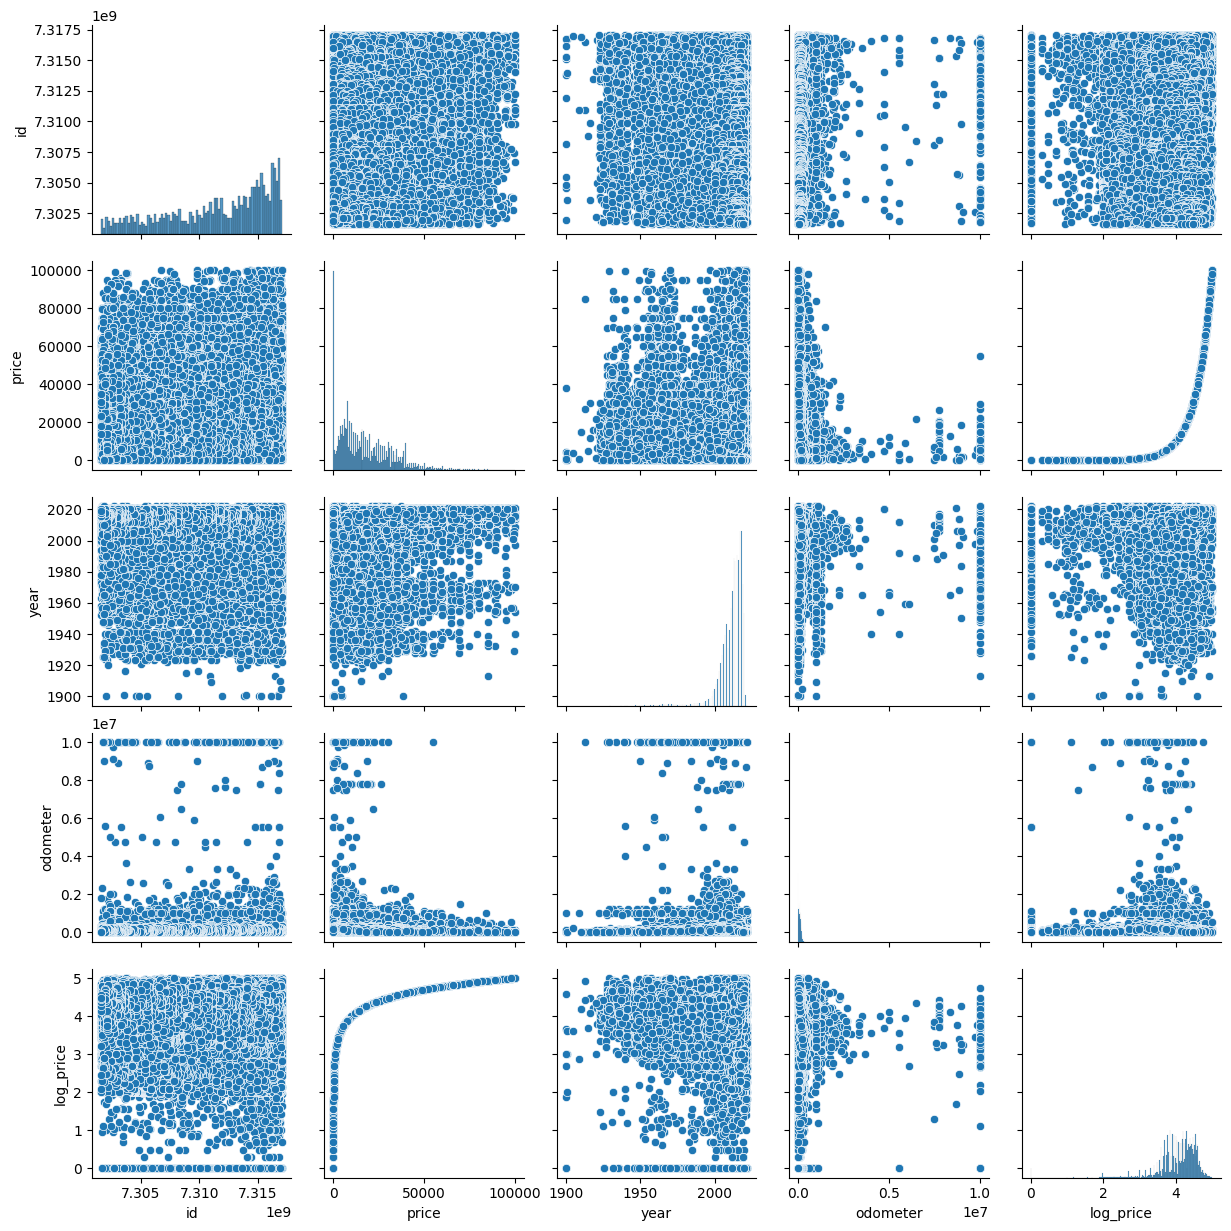

In [49]:
sns.pairplot(cars3)

In [9]:
## I eliminated several columns, either the ones which don't affect the car price much or the features with
## multiple unique categories since that will make the data pre-processing and model building too expensive.
cars3 = cars3.drop(['id','region','paint_color','state','model','manufacturer'], axis=1)
cars3 = cars3.drop(['VIN'], axis=1)
objects_df = cars3.select_dtypes(include='object')
objects_cols = objects_df.columns
objects_cols

Index(['condition', 'cylinders', 'fuel', 'title_status', 'transmission',
       'drive', 'size', 'type'],
      dtype='object')

In [15]:
cars_numeric = pd.get_dummies(objects_df)

In [16]:
cars_numeric = pd.concat([cars3[['year','odometer','price']], cars_numeric], axis=1)
cars_numeric.head()

,year,odometer,price,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_null,condition_salvage,...,type_hatchback,type_mini-van,type_null,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon
27,2014.0,57923.0,33590,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
28,2010.0,71229.0,22590,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
29,2020.0,19160.0,39590,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
30,2017.0,41124.0,30990,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
31,2013.0,128000.0,15000,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [10]:
## Check which manufacturers are the most expensive
cars4 = cars2[cars2['price'] < 1e5]
manufacturer = cars4.groupby('manufacturer')[['price']].agg('mean')
manufacturer = manufacturer.sort_values(by='price', ascending=False)
manufacturer

,price
manufacturer,
ferrari,52203.792453
aston-martin,39909.047619
tesla,38288.474537
porsche,28583.873134
alfa-romeo,28162.455157
ram,26765.621334
rover,26476.597590
jaguar,26362.336603
audi,23216.726594


In [11]:
cars_numeric.columns

Index(['year', 'odometer', 'price', 'condition_excellent', 'condition_fair',
       'condition_good', 'condition_like new', 'condition_new',
       'condition_null', 'condition_salvage', 'cylinders_10 cylinders',
       'cylinders_12 cylinders', 'cylinders_3 cylinders',
       'cylinders_4 cylinders', 'cylinders_5 cylinders',
       'cylinders_6 cylinders', 'cylinders_8 cylinders', 'cylinders_null',
       'cylinders_other', 'fuel_diesel', 'fuel_electric', 'fuel_gas',
       'fuel_hybrid', 'fuel_null', 'fuel_other', 'title_status_clean',
       'title_status_lien', 'title_status_missing', 'title_status_null',
       'title_status_parts only', 'title_status_rebuilt',
       'title_status_salvage', 'transmission_automatic', 'transmission_manual',
       'transmission_null', 'transmission_other', 'drive_4wd', 'drive_fwd',
       'drive_null', 'drive_rwd', 'size_compact', 'size_full-size',
       'size_mid-size', 'size_null', 'size_sub-compact', 'type_SUV',
       'type_bus', 'type_convert

In [17]:
## Drop the columns with *_null since these are the NaN/null values for the categorical data
null_list = ['condition_null','cylinders_null','fuel_null','title_status_null','transmission_null','drive_null',\
            'size_null','type_null']
cars_numeric = cars_numeric.drop(null_list, axis=1)

In [13]:
cars_numeric.columns

Index(['year', 'odometer', 'price', 'condition_excellent', 'condition_fair',
       'condition_good', 'condition_like new', 'condition_new',
       'condition_salvage', 'cylinders_10 cylinders', 'cylinders_12 cylinders',
       'cylinders_3 cylinders', 'cylinders_4 cylinders',
       'cylinders_5 cylinders', 'cylinders_6 cylinders',
       'cylinders_8 cylinders', 'cylinders_other', 'fuel_diesel',
       'fuel_electric', 'fuel_gas', 'fuel_hybrid', 'fuel_other',
       'title_status_clean', 'title_status_lien', 'title_status_missing',
       'title_status_parts only', 'title_status_rebuilt',
       'title_status_salvage', 'transmission_automatic', 'transmission_manual',
       'transmission_other', 'drive_4wd', 'drive_fwd', 'drive_rwd',
       'size_compact', 'size_full-size', 'size_mid-size', 'size_sub-compact',
       'type_SUV', 'type_bus', 'type_convertible', 'type_coupe',
       'type_hatchback', 'type_mini-van', 'type_offroad', 'type_other',
       'type_pickup', 'type_sedan', 'ty

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [13]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Text(0.5, 1.0, 'Histogram of Used Car Prices')

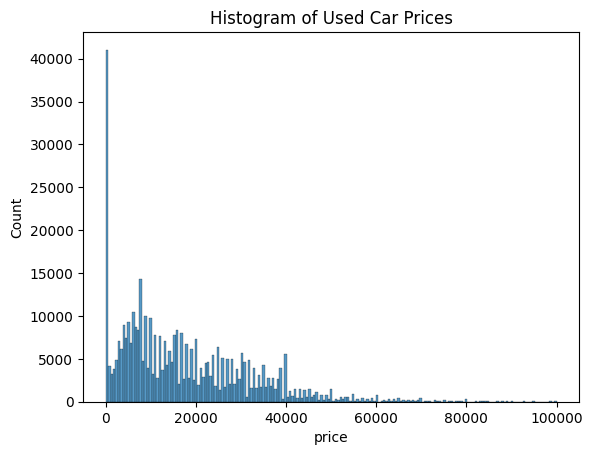

In [19]:
## This was done to show amount of rows/samples that have price=0 within the dataset.
sns.histplot(cars_numeric['price'])
plt.title('Histogram of Used Car Prices')

In [20]:
## Drop the rows/samples with price=0, since car dealers won't make money with that price.
cars_numeric = cars_numeric[cars_numeric['price'] != 0]
cars_numeric.shape

(389897, 51)

In [21]:
## Split the data into X (features) and y (target which is price), and then split into training and test sets
X = cars_numeric.drop('price', axis=1)
y = cars_numeric['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [17]:
## Start with a linear regression model, with feature selection of 10 features, and also with data
## standardized/scaled.
pipe_sfs = Pipeline([\
                    ('scaler', StandardScaler()),\
                    ('selector', SequentialFeatureSelector(estimator=LinearRegression(),\
                                                        n_features_to_select=10)),\
                    ('linreg', LinearRegression())])
pipe_sfs

Pipeline(steps=[('scaler', StandardScaler()),
                ('selector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=10)),
                ('linreg', LinearRegression())])

In [18]:
# Fit SFS (Sequential Feature Selection) Linear regression model and then compute MSE for both training and test data
pipe_sfs.fit(X_train, y_train)
model = pipe_sfs.named_steps['linreg']
print(model)
y_pred = pipe_sfs.predict(X_train)
mse_sfs_train = float(mean_squared_error(y_pred, y_train))
y_pred = pipe_sfs.predict(X_test)
mse_sfs_test = float(mean_squared_error(y_pred, y_test))
print(f"MSE SFS train: {mse_sfs_train}")
print(f"MSE SFS test: {mse_sfs_test}")

LinearRegression()
MSE SFS train: 132910581.23152146
MSE SFS test: 134064727.87832169


In [19]:
# Extract the selected features
sel_tf = pipe_sfs.named_steps['selector'].get_support()
Xcols = list(X.columns)
sel_inds = []
for i, val in enumerate(sel_tf):
    if val: sel_inds.append(i)
selected_features = [Xcols[i] for i in sel_inds]
selected_features

['year',
 'odometer',
 'cylinders_4 cylinders',
 'cylinders_8 cylinders',
 'fuel_diesel',
 'fuel_gas',
 'transmission_other',
 'drive_fwd',
 'type_pickup',
 'type_truck']

In [20]:
## Since initial model is not fitting well, I am trying different approaches.
## First, I am checking which categorical encoded columns have too many zeros.
X.sum()

year                       7.840842e+08
odometer                   3.859188e+10
condition_excellent        9.352500e+04
condition_fair             6.719000e+03
condition_good             1.189510e+05
condition_like new         1.998900e+04
condition_new              1.107000e+03
condition_salvage          5.950000e+02
cylinders_10 cylinders     1.329000e+03
cylinders_12 cylinders     1.660000e+02
cylinders_3 cylinders      5.990000e+02
cylinders_4 cylinders      7.233200e+04
cylinders_5 cylinders      1.657000e+03
cylinders_6 cylinders      8.793700e+04
cylinders_8 cylinders      6.587400e+04
cylinders_other            1.079000e+03
fuel_diesel                2.606200e+04
fuel_electric              1.617000e+03
fuel_gas                   3.272410e+05
fuel_hybrid                4.867000e+03
fuel_other                 2.798700e+04
title_status_clean         3.694420e+05
title_status_lien          1.415000e+03
title_status_missing       7.850000e+02
title_status_parts only    1.880000e+02


In [21]:
## Deleting the columns with < 10000 1's for the categorical encoded columns.
## Since only a small fraction of the samples have these categories, these won't have much impact on 
## car price prediction.  Total of 389897 samples.
## 10000/389897 = 2.6%
cols_to_drop = ['condition_fair', 'condition_new', 'condition_salvage', 'cylinders_10 cylinders',\
               'cylinders_12 cylinders', 'cylinders_3 cylinders', 'cylinders_5 cylinders', 'cylinders_other',\
               'fuel_electric', 'fuel_hybrid', 'title_status_lien', 'title_status_missing', 'title_status_parts only',\
               'title_status_rebuilt', 'title_status_salvage', 'size_sub-compact', 'type_bus', 'type_convertible', \
               'type_mini-van', 'type_offroad', 'type_van']
X = X.drop(columns=cols_to_drop)

In [22]:
X.shape

(389897, 29)

In [23]:
## Re-split into train and test after dropping the columns above
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [24]:
pipe_sfs = Pipeline([\
                    ('scaler', StandardScaler()),\
                    ('selector', SequentialFeatureSelector(estimator=LinearRegression(),\
                                                        n_features_to_select=10)),\
                    ('linreg', LinearRegression())])
pipe_sfs

Pipeline(steps=[('scaler', StandardScaler()),
                ('selector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=10)),
                ('linreg', LinearRegression())])

In [25]:
# Fit SFS (Sequential Feature Selection) Linear regression model and then compute MSE for both training and test data
pipe_sfs.fit(X_train, y_train)
model = pipe_sfs.named_steps['linreg']
print(model)
y_pred = pipe_sfs.predict(X_train)
mse_sfs_train = float(mean_squared_error(y_pred, y_train))
y_pred = pipe_sfs.predict(X_test)
mse_sfs_test = float(mean_squared_error(y_pred, y_test))
print(f"MSE SFS train: {mse_sfs_train}")
print(f"MSE SFS test: {mse_sfs_test}")

LinearRegression()
MSE SFS train: 132910581.23152146
MSE SFS test: 134064727.87832169


In [26]:
# Extract the selected features
sel_tf = pipe_sfs.named_steps['selector'].get_support()
Xcols = list(X.columns)
sel_inds = []
for i, val in enumerate(sel_tf):
    if val: sel_inds.append(i)
selected_features = [Xcols[i] for i in sel_inds]
selected_features

['year',
 'odometer',
 'cylinders_4 cylinders',
 'cylinders_8 cylinders',
 'fuel_diesel',
 'fuel_gas',
 'transmission_other',
 'drive_fwd',
 'type_pickup',
 'type_truck']

In [27]:
# extract coefs for SFS model
model = pipe_sfs.named_steps['linreg']
sfs_coefs = model.coef_
sfs_df = pd.DataFrame({'features':selected_features, 'coefficients': sfs_coefs})
sfs_df

,features,coefficients
0,year,4437.179366
1,odometer,-1682.484492
2,cylinders_4 cylinders,-1498.964991
3,cylinders_8 cylinders,1219.100050
4,fuel_diesel,2519.333264
5,fuel_gas,-1133.875212
6,transmission_other,2383.910680
7,drive_fwd,-2228.204460
8,type_pickup,1574.854384
9,type_truck,1296.606213


In [28]:
# sweep alpha to find best ridge model
ridge_pipe = Pipeline([\
                      ('scaler', StandardScaler()),\
                      ('ridge', Ridge())])
ridge_param_dict = {'ridge__alpha': np.logspace(0, 10, 50)}
ridge_grid = GridSearchCV(estimator=ridge_pipe,\
                         param_grid=ridge_param_dict)
ridge_grid

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([1.00000000e+00, 1.59985872e+00, 2.55954792e+00, 4.09491506e+00,
       6.55128557e+00, 1.04811313e+01, 1.67683294e+01, 2.68269580e+01,
       4.29193426e+01, 6.86648845e+01, 1.09854114e+02, 1.75751062e+02,
       2.81176870e+02, 4.49843267e+02, 7.19685673e+02, 1.15...
       7.90604321e+04, 1.26485522e+05, 2.02358965e+05, 3.23745754e+05,
       5.17947468e+05, 8.28642773e+05, 1.32571137e+06, 2.12095089e+06,
       3.39322177e+06, 5.42867544e+06, 8.68511374e+06, 1.38949549e+07,
       2.22299648e+07, 3.55648031e+07, 5.68986603e+07, 9.10298178e+07,
       1.45634848e+08, 2.32995181e+08, 3.72759372e+08, 5.96362332e+08,
       9.54095476e+08, 1.52641797e+09, 2.44205309e+09, 3.90693994e+09,
       6.25055193e+09, 1.00000000e+10])})

In [29]:
# fit data and compute MSE
ridge_grid.fit(X, y)
model = ridge_grid.best_estimator_
y_pred = model.predict(X_train)
mse_ridge_train = float(mean_squared_error(y_pred, y_train))
y_pred = model.predict(X_test)
mse_ridge_test = float(mean_squared_error(y_pred, y_test))
print(f"MSE ridge train: {mse_ridge_train}")
print(f"MSE ridge test: {mse_ridge_test}")

MSE ridge train: 124875336.18942288
MSE ridge test: 125752428.6735835


In [30]:
model.named_steps['ridge']

Ridge(alpha=4714.866363457394)

In [31]:
# Get the coefficients for the ridge model
ridge_coefs = model.named_steps['ridge'].coef_
ridge_df = pd.DataFrame({'features':list(X_train.columns), 'coefficients': ridge_coefs})
ridge_df = ridge_df.sort_values(by='coefficients', ascending=False)
ridge_df

,features,coefficients
0,year,4308.576722
8,fuel_diesel,2589.497992
15,drive_4wd,1875.174850
14,transmission_other,1795.822194
25,type_pickup,1594.019065
27,type_truck,1421.679910
17,drive_rwd,1333.556544
24,type_other,1118.841333
7,cylinders_8 cylinders,948.940917
22,type_coupe,921.543674


In [32]:
## Reduce the # of features further, keeping the most important ones based on coefficients from above dataframe.
## Keeping the top 7, plus cylinders_8 cylinders, and also odometer and cylinders_4 cylinders, since there is strong inverse relationship
## between odometer and cylinders_4 cylinders vs. price.
## I omitted type_other since I didn't want too many *_other columns and I felt including 8-cylinder would be
## more insightful in creating the model.  # of cylinders does affect car price.
## Most positive coefficients are the ones that drive used car prices up, and the most negative coefficients
## are the ones that drive car prices down.
X2 = X[['year','fuel_diesel','drive_4wd','transmission_other','type_pickup',\
        'type_truck', 'drive_rwd','cylinders_8 cylinders','odometer','cylinders_4 cylinders']]
y_scale = (y - y.mean()) / y.std()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X2, y_scale, random_state = 42)

In [34]:
# sweep alpha to find best ridge model
ridge_pipe = Pipeline([\
                      ('scaler', StandardScaler()),\
                      ('ridge', Ridge())])
ridge_param_dict = {'ridge__alpha': np.logspace(0, 10, 50)}
ridge_grid = GridSearchCV(estimator=ridge_pipe,\
                         param_grid=ridge_param_dict,\
                         scoring='neg_mean_squared_error',\
                         cv=20)
ridge_grid

GridSearchCV(cv=20,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([1.00000000e+00, 1.59985872e+00, 2.55954792e+00, 4.09491506e+00,
       6.55128557e+00, 1.04811313e+01, 1.67683294e+01, 2.68269580e+01,
       4.29193426e+01, 6.86648845e+01, 1.09854114e+02, 1.75751062e+02,
       2.81176870e+02, 4.49843267e+02, 7.19685673e+0...
       5.17947468e+05, 8.28642773e+05, 1.32571137e+06, 2.12095089e+06,
       3.39322177e+06, 5.42867544e+06, 8.68511374e+06, 1.38949549e+07,
       2.22299648e+07, 3.55648031e+07, 5.68986603e+07, 9.10298178e+07,
       1.45634848e+08, 2.32995181e+08, 3.72759372e+08, 5.96362332e+08,
       9.54095476e+08, 1.52641797e+09, 2.44205309e+09, 3.90693994e+09,
       6.25055193e+09, 1.00000000e+10])},
             scoring='neg_mean_squared_error')

In [35]:
# fit data and compute MSE
ridge_grid.fit(X2, y_scale)
model = ridge_grid.best_estimator_
y_pred = model.predict(X_train)
mse_ridge_train = float(mean_squared_error(y_pred, y_train))
y_pred = model.predict(X_test)
mse_ridge_test = float(mean_squared_error(y_pred, y_test))
print(f"MSE ridge train: {mse_ridge_train}")
print(f"MSE ridge test: {mse_ridge_test}")

MSE ridge train: 0.640067240415616
MSE ridge test: 0.6457643547021552


In [36]:
model.named_steps['ridge']

Ridge(alpha=1842.0699693267163)

In [42]:
pipe = Pipeline([\
                ('features', PolynomialFeatures(degree=3)),\
                ('scaler', StandardScaler()),\
                ('linreg', LinearRegression())])

pipe

Pipeline(steps=[('features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()), ('linreg', LinearRegression())])

In [43]:
from sklearn.model_selection import cross_val_score
# fit data and compute score
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_train)
mse_train = float(mean_squared_error(y_pred, y_train))
y_pred = pipe.predict(X_test)
mse_test = float(mean_squared_error(y_pred, y_test))
print(f"MSE train: {mse_train}")
print(f"MSE test: {mse_test}")
model = pipe.named_steps['linreg']
scores = cross_val_score(model, X_test, y_test, cv=20)
print('cv_scores mean:{}'.format(np.mean(scores)))
print("degree = 3")

MSE train: 0.3788141402079695
MSE test: 0.3839209349927752
cv_scores mean:0.3578342441093977
degree = 3


In [44]:
pipe = Pipeline([\
                ('features', PolynomialFeatures(degree=2)),\
                ('scaler', StandardScaler()),\
                ('linreg', LinearRegression())])

pipe

Pipeline(steps=[('features', PolynomialFeatures()),
                ('scaler', StandardScaler()), ('linreg', LinearRegression())])

In [45]:
from sklearn.model_selection import cross_val_score
# fit data and compute score
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_train)
mse_train = float(mean_squared_error(y_pred, y_train))
y_pred = pipe.predict(X_test)
mse_test = float(mean_squared_error(y_pred, y_test))
print(f"MSE train: {mse_train}")
print(f"MSE test: {mse_test}")
model = pipe.named_steps['linreg']
scores = cross_val_score(model, X_test, y_test, cv=20)
print('cv_scores mean:{}'.format(np.mean(scores)))
print("degree = 2")

MSE train: 0.43535022568184684
MSE test: 0.4414710582425976
cv_scores mean:0.3578342441093977
degree = 2


In [46]:
pipe = Pipeline([\
                ('features', PolynomialFeatures(degree=1)),\
                ('scaler', StandardScaler()),\
                ('linreg', LinearRegression())])

pipe

Pipeline(steps=[('features', PolynomialFeatures(degree=1)),
                ('scaler', StandardScaler()), ('linreg', LinearRegression())])

In [47]:
from sklearn.model_selection import cross_val_score
# fit data and compute score
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_train)
mse_train = float(mean_squared_error(y_pred, y_train))
y_pred = pipe.predict(X_test)
mse_test = float(mean_squared_error(y_pred, y_test))
print(f"MSE train: {mse_train}")
print(f"MSE test: {mse_test}")
model = pipe.named_steps['linreg']
scores = cross_val_score(model, X_test, y_test, cv=20)
print('cv_scores mean:{}'.format(np.mean(scores)))
print("degree = 1")

MSE train: 0.6400278425444077
MSE test: 0.6460060448637256
cv_scores mean:0.3578342441093977
degree = 1


In [48]:
pipe = Pipeline([\
                ('features', PolynomialFeatures(degree=4)),\
                ('scaler', StandardScaler()),\
                ('linreg', LinearRegression())])

pipe

Pipeline(steps=[('features', PolynomialFeatures(degree=4)),
                ('scaler', StandardScaler()), ('linreg', LinearRegression())])

In [49]:
from sklearn.model_selection import cross_val_score
# fit data and compute score
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_train)
mse_train = float(mean_squared_error(y_pred, y_train))
y_pred = pipe.predict(X_test)
mse_test = float(mean_squared_error(y_pred, y_test))
print(f"MSE train: {mse_train}")
print(f"MSE test: {mse_test}")
model = pipe.named_steps['linreg']
scores = cross_val_score(model, X_test, y_test, cv=20)
print('cv_scores mean:{}'.format(np.mean(scores)))
print("degree = 4")

MSE train: 0.3618675452619705
MSE test: 4.896504153112442e+18
cv_scores mean:0.3578342441093977
degree = 4


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [18]:
## After some initial model creation to narrow down the list of input features to the most important ones, 
## as well as standardizing the target variable (price) to get the MSE down from some very high value to
## something between 0 and 1 as we expect, I did the polynomial degree sweep as the final step to finalize on
## the optimal model.  I got the list of MSE values from the computations I did above.
degrees = [1,2,3,4]
mse_trains = [0.6400278425444077, 0.43535022568184684, 0.3788141402079695, 0.3618675452619705]
mse_tests = [0.6460060448637256, 0.4414710582425976, 0.3839209349927752, 4.896504153112442e+18]

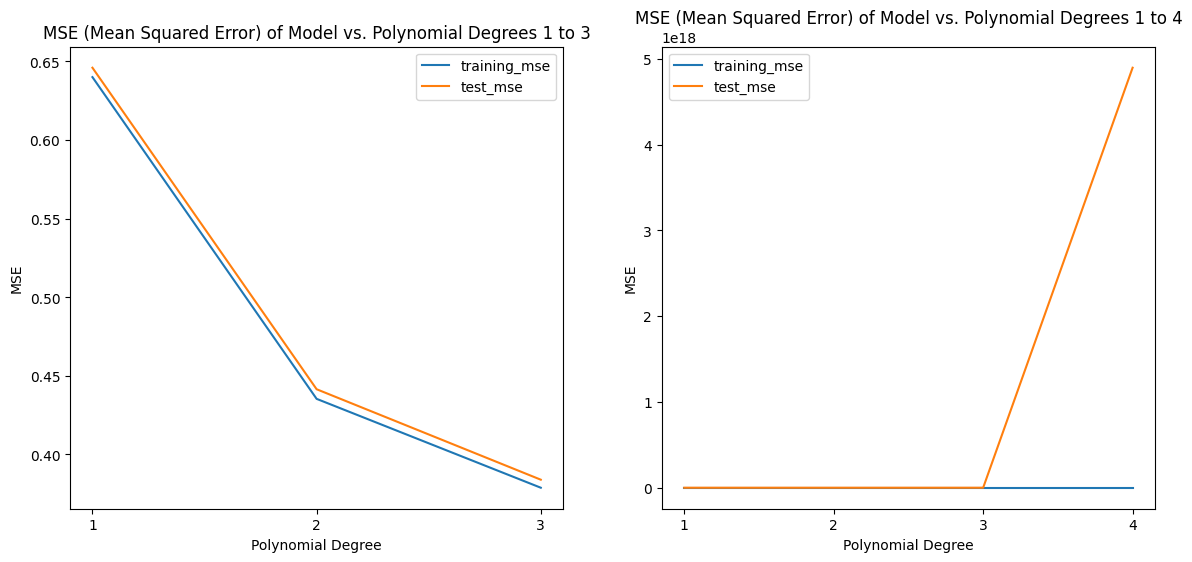

In [27]:
## Plots of MSE (mean squared error) vs. polynomial degree.
## MSE is the main metric used for model quality.
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
ax[0].plot(degrees[:3], mse_trains[:3], label='training_mse')
ax[0].plot(degrees[:3], mse_tests[:3], label='test_mse')
ax[0].set_title('MSE (Mean Squared Error) of Model vs. Polynomial Degrees 1 to 3')
ax[0].set_xlabel('Polynomial Degree')
ax[0].set_ylabel('MSE')
ax[0].set_xticks([1,2,3])
ax[0].legend()
ax[1].plot(degrees, mse_trains, label='training_mse')
ax[1].plot(degrees, mse_tests, label='test_mse')
ax[1].set_title('MSE (Mean Squared Error) of Model vs. Polynomial Degrees 1 to 4')
ax[1].set_xlabel('Polynomial Degree')
ax[1].set_ylabel('MSE')
ax[1].set_xticks([1,2,3,4])
ax[1].legend()

__Above plots show these:__ 

__1) Degrees 1 and 2 are underfitted since both training and test MSE are high.__

__2) Degree 4 is overfitted since test MSE is much greater than training MSE.__

__3) Polynomial regression of degree 3 is the optimal model that got selected for deployment.__

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

In [27]:
## Deployed model below, with polynomial degree=3, with pipe3 as the Pipelined model variable.  
## Reasoning for choosing certain features is already explained above.
X = X[['year','fuel_diesel','drive_4wd','transmission_other','type_pickup',\
        'type_truck', 'drive_rwd','cylinders_8 cylinders','odometer','cylinders_4 cylinders']]
y_scale = (y - y.mean()) / y.std()

In [23]:
y.mean()

18655.321292546494

In [24]:
y.std()

14437.62491256523

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y_scale, random_state = 42)

In [25]:
pipe3 = Pipeline([\
                ('features', PolynomialFeatures(degree=3)),\
                ('scaler', StandardScaler()),\
                ('linreg', LinearRegression())])

pipe3

Pipeline(steps=[('features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()), ('linreg', LinearRegression())])

In [29]:
## Re-validating this model with degree=3 before final deployment, as sanity check.
from sklearn.model_selection import cross_val_score
# fit data and compute score
pipe3.fit(X_train, y_train)
y_pred = pipe3.predict(X_train)
mse_train = float(mean_squared_error(y_pred, y_train))
y_pred = pipe3.predict(X_test)
mse_test = float(mean_squared_error(y_pred, y_test))
print(f"MSE train: {mse_train}")
print(f"MSE test: {mse_test}")
model = pipe3.named_steps['linreg']
scores = cross_val_score(model, X_test, y_test, cv=20)
print('cv_scores mean:{}'.format(np.mean(scores)))
print("degree = 3")

MSE train: 0.3788141402079695
MSE test: 0.3839209349927752
cv_scores mean:0.3578342441093977
degree = 3


__Summary and Key Findings:__
Polynomial regression model of degree 3, a cubic model, has been created and selected as the most optimal, in order to predict used car prices using certain characteristics that are considered to be most important for a typical used vehicle.  These findings below from the model correlate closely to the pre-model data analysis that was done.

The question of which features drive used car prices up and which features drive used car prices down are answered below using this model:

__Most important features that drive used car prices up:__
* Year of the vehicle (newer vehicles will cost more compared to older vehicles)
* Diesel fuel
* Vehicle needs to be either all-wheel drive (AWD/4WD) or rear-wheel drive (RWD)
* Vehicle needs to be either a truck or a pickup
* 8-cylinder vehicles
* Other types of transmission, which are neither automatic nor manual.  Specifics of "other" to be determined by the used car dealers.

__Most important features that drive used car prices down:__
* 4-cylinder vehicles
* odometer mileage

__Recommendations for the used car dealers:__
* Increase the stock of vehicles which fall in the category of features driving prices up, mentioned above.  This includes the high end large vehicles, such as trucks and pickups, which typically use 8-cylinder and diesel fuel and are all-wheel drive.  Also it is necessary to make sure only the newer used cars with less total miles driven are brought into stock.
* Reduce the stock of vehicles which fall in the category of features driving prices down, mentioned above.  This includes 4-cylinder vehicles as well as vehicles that are too old with too many miles driven.
* The features driving used car prices up are the ones that customers want to see.